Мышковец С.А., v.01 30.10.2022

Решение задачи: Построить модель машинного обучения для предсказания вероятности того, что клиент уйдет в просрочку более 60 дней (delinq60plus).

В данной задаче нам представлены данные в которых ключевое поле — это то, просрочит ли клиент микро-финансовой организации выплату более чем на 60 дней или нет. 

Задачи:
1.  осуществить корректную загрузку данных
2.  осуществить разведывательный анализ данных:
- разбить выборку на обучающую и тестовую
- проанализировать пропуски и решить, что с ними делать
- удалить дубликаты
- проанализировать выбросы
- создать/ удалить переменные
- закодировать категориальные переменные
- нормализовать числовые переменные (при необходимости)
3. построить модель и оценить ее качество
4. при необходимости вернуться к предыдущим шагам, чтобы улучшить качество модели


Использовать (не везде, а где мы работаем с данными напрямую) SQL запросы. 


Вывод: 

1. Максимальный результат rfc auc на скалированных и нескалированных данных - 0.832
2. Очистка БД особых результатов не принесла: разница составила 0.01 в пользу неочищенных данных
3. Замена значений "Пропуск поля" также знаительно не повялияла на результат (0.830).
4. **Максимальный результат rfc auc на скалированных данных - 0.833 при разделе БД на тренировочную и тестовую части до очистки БД.**

# 1. Осуществить корректную загрузку данных

In [1]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 50)
df = pd.read_csv("MFOcredit.csv", sep= ';')

In [2]:
df.head()

,id,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,1,03-Jan-2013,12-Jan-2013,Мужской,44,Нет,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Новосибирская область,Нет,Да,Нет
1,2,03-Jan-2013,17-Jan-2013,Мужской,21,Пропуск поля,Живут с родителями,Холост,Нет,Официальное,Кемеровская область юг,Да,Нет,Нет
2,3,03-Jan-2013,17-Jan-2013,Мужской,25,Пропуск поля,Собственное,Холост,Да,Официальное,Кемеровская область север,Пропуск поля,Нет,Нет
3,4,03-Jan-2013,17-Jan-2013,Женский,47,Пропуск поля,Собственное,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область север,Нет,Нет,Нет
4,5,03-Jan-2013,17-Jan-2013,Мужской,22,Нет,Арендуемое,Гражданский брак/женат/замужем,Нет,Официальное,Кемеровская область север,Да,Да,Нет


# 2. Осуществить разведывательный анализ данных:

## Проанализировать пропуски и решить, что с ними делать

In [3]:
df.describe()

,id,age
count,35212.000000,35212.000000
mean,17606.500000,37.243525
std,10164.973176,13.183961
min,1.000000,18.000000
25%,8803.750000,26.000000
50%,17606.500000,34.000000
75%,26409.250000,48.000000
max,35212.000000,75.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35212 entries, 0 to 35211
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            35212 non-null  int64 
 1   date_start    35212 non-null  object
 2   date_end      35212 non-null  object
 3   gender        35212 non-null  object
 4   age           35212 non-null  int64 
 5   auto          35212 non-null  object
 6   housing       35212 non-null  object
 7   marstatus     35212 non-null  object
 8   regclient     35212 non-null  object
 9   jobtype       35212 non-null  object
 10  region        35212 non-null  object
 11  credits       35212 non-null  object
 12  children      35212 non-null  object
 13  delinq60plus  35212 non-null  object
dtypes: int64(2), object(12)
memory usage: 3.8+ MB


In [5]:
df.isna().sum()

id              0
date_start      0
date_end        0
gender          0
age             0
auto            0
housing         0
marstatus       0
regclient       0
jobtype         0
region          0
credits         0
children        0
delinq60plus    0
dtype: int64

**Пропусков, NaN и нулевых значений в БД нет.**

In [6]:
df.groupby("gender")["id"].count().sort_values()

gender
Мужской    16937
Женский    18275
Name: id, dtype: int64

In [7]:
df.groupby("auto")["id"].count().sort_values()

auto
Да               3670
Пропуск поля    14077
Нет             17465
Name: id, dtype: int64

In [8]:
df.groupby("housing")["id"].count().sort_values()

housing
Муниципальное             1358
Арендуемое                2020
Долевая собственность     2955
Живут с родителями        3177
Пропуск поля              7603
Собственное              18099
Name: id, dtype: int64

In [9]:
df.groupby("marstatus")["id"].count().sort_values()

marstatus
Вдова/вдовец                       1845
Разведен                           2871
Пропуск поля                       7564
Холост                             8833
Гражданский брак/женат/замужем    14099
Name: id, dtype: int64

In [10]:
df.groupby("regclient")["id"].count().sort_values()

regclient
Нет    15479
Да     19733
Name: id, dtype: int64

In [11]:
df.groupby("jobtype")["id"].count().sort_values()

jobtype
Неофициальное     1167
Пропуск поля     14457
Официальное      19588
Name: id, dtype: int64

In [12]:
df.groupby("region")["id"].count().sort_values()

region
Красноярский край             2244
Новосибирская область         4327
Алтайский край                5172
Кемеровская область юг       11022
Кемеровская область север    12447
Name: id, dtype: int64

In [13]:
df.groupby("credits")["id"].count().sort_values()

credits
Пропуск поля      946
Да              16140
Нет             18126
Name: id, dtype: int64

In [14]:
df.groupby("children")["id"].count().sort_values()

children
Пропуск поля      745
Да              13326
Нет             21141
Name: id, dtype: int64

**Есть колонки ("auto", "housing", "marstatus", "jobtype", "credits", "children") со значением "Пропуск поля"**

<AxesSubplot:>

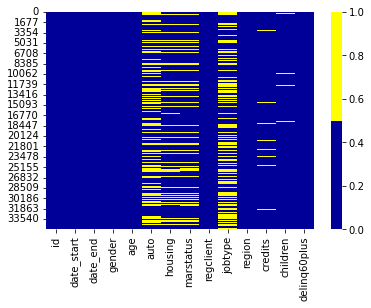

In [15]:
import seaborn as sns
cols = df.columns
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols]=='Пропуск поля', cmap=sns.color_palette(colours))

In [16]:
df_4_Nan = df[(df['auto']=='Пропуск поля') & (df['housing']=='Пропуск поля') & (df['marstatus']=='Пропуск поля') & (df['jobtype']=='Пропуск поля')]

In [17]:
df_4_Nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6422 entries, 8 to 35211
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            6422 non-null   int64 
 1   date_start    6422 non-null   object
 2   date_end      6422 non-null   object
 3   gender        6422 non-null   object
 4   age           6422 non-null   int64 
 5   auto          6422 non-null   object
 6   housing       6422 non-null   object
 7   marstatus     6422 non-null   object
 8   regclient     6422 non-null   object
 9   jobtype       6422 non-null   object
 10  region        6422 non-null   object
 11  credits       6422 non-null   object
 12  children      6422 non-null   object
 13  delinq60plus  6422 non-null   object
dtypes: int64(2), object(12)
memory usage: 752.6+ KB


In [18]:
# **Удаляем строки, в которых 4 колонки имееют значение "Пропуск поля"**

In [19]:
# df.drop(df[(df['auto']=='Пропуск поля') & (df['housing']=='Пропуск поля') & (df['marstatus']=='Пропуск поля') & (df['jobtype']=='Пропуск поля')].index, inplace = True)

In [20]:
# df.info()

In [21]:
# df.groupby("jobtype")["id"].count().sort_values()

In [22]:
# **Удаляем колонку 'jobtype', т.к. 48% данных неизвестны**

In [23]:
# df = df.drop(['jobtype'], axis=1)

In [24]:
# df.columns

In [25]:
# df.groupby("auto")["id"].count().sort_values()

**Учитывая 25% пропусков в колонке 'auto', исходим из худших финансовых гарантий и меняем значение 'Пропуск поля' на 'Нет'**

In [26]:
df["auto"] = df["auto"].replace("Пропуск поля", "Нет", regex=True)

**Исходим из худших финансовых гарантий и меняем значение колонки "housing" с 'Пропуск поля' на 'Арендуемое'**

In [27]:
df["housing"] = df["housing"].replace("Пропуск поля", "Арендуемое", regex=True)

In [28]:
df.loc[df["children"] == "Да", "marstatus"] = "Гражданский брак/женат/замужем"

In [29]:
df["marstatus"] = df["marstatus"].replace("Пропуск поля", "Разведен", regex=True)

In [30]:
df["credits"] = df["credits"].replace("Пропуск поля", "Да", regex=True)

In [31]:
df["children"] = df["children"].replace("Пропуск поля", "Да", regex=True)

In [32]:
df["credits"] = df["credits"].replace("Да", 1 , regex=True)
df["credits"] = df["credits"].replace("Нет", 0 , regex=True)

In [33]:
df["regclient"] = df["regclient"].replace("Нет", 0 , regex=True)
df["regclient"] = df["regclient"].replace("Да", 1 , regex=True)

In [34]:
df["auto"] = df["auto"].replace("Нет", 0 , regex=True)
df["auto"] = df["auto"].replace("Да", 1 , regex=True)

In [35]:
df["children"] = df["children"].replace("Нет", 0 , regex=True)
df["children"] = df["children"].replace("Да", 1 , regex=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35212 entries, 0 to 35211
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            35212 non-null  int64 
 1   date_start    35212 non-null  object
 2   date_end      35212 non-null  object
 3   gender        35212 non-null  object
 4   age           35212 non-null  int64 
 5   auto          35212 non-null  int64 
 6   housing       35212 non-null  object
 7   marstatus     35212 non-null  object
 8   regclient     35212 non-null  int64 
 9   jobtype       35212 non-null  object
 10  region        35212 non-null  object
 11  credits       35212 non-null  int64 
 12  children      35212 non-null  int64 
 13  delinq60plus  35212 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.8+ MB


# Удалить дубликаты

In [37]:
column_names = ['date_start', 'date_end', 'gender', 'age', 'auto', 'marstatus', 'region', 'housing', 'regclient', 'credits']

In [38]:
duplicates = df.duplicated(subset=column_names, keep=False)

In [39]:
df[duplicates].sort_values(by='id')

,id,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
91,92,05-Jan-2013,19-Jan-2013,Женский,38,0,Собственное,Гражданский брак/женат/замужем,0,Официальное,Кемеровская область север,1,1,Да
99,100,05-Jan-2013,19-Jan-2013,Женский,38,0,Собственное,Гражданский брак/женат/замужем,0,Пропуск поля,Кемеровская область север,1,1,Да
1100,1101,29-Jan-2013,12-Feb-2013,Мужской,26,0,Собственное,Гражданский брак/женат/замужем,0,Официальное,Кемеровская область юг,0,1,Да
1114,1115,29-Jan-2013,12-Feb-2013,Мужской,26,0,Собственное,Гражданский брак/женат/замужем,0,Официальное,Кемеровская область юг,0,0,Да
1501,1502,06-Feb-2013,20-Feb-2013,Женский,33,0,Собственное,Гражданский брак/женат/замужем,1,Пропуск поля,Кемеровская область север,0,1,Да
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35101,35102,03-Jan-2014,17-Jan-2014,Женский,23,0,Арендуемое,Разведен,0,Пропуск поля,Кемеровская область юг,0,0,Нет
35114,35115,03-Jan-2014,17-Jan-2014,Женский,35,0,Собственное,Гражданский брак/женат/замужем,1,Пропуск поля,Кемеровская область север,0,1,Нет
35122,35123,03-Jan-2014,17-Jan-2014,Женский,63,0,Собственное,Вдова/вдовец,1,Пропуск поля,Кемеровская область север,1,0,Нет
35141,35142,03-Jan-2014,17-Jan-2014,Женский,23,0,Арендуемое,Разведен,0,Пропуск поля,Кемеровская область юг,0,0,Нет


In [40]:
df.drop_duplicates(subset=column_names, keep=False, inplace=True)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34660 entries, 0 to 35211
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            34660 non-null  int64 
 1   date_start    34660 non-null  object
 2   date_end      34660 non-null  object
 3   gender        34660 non-null  object
 4   age           34660 non-null  int64 
 5   auto          34660 non-null  int64 
 6   housing       34660 non-null  object
 7   marstatus     34660 non-null  object
 8   regclient     34660 non-null  int64 
 9   jobtype       34660 non-null  object
 10  region        34660 non-null  object
 11  credits       34660 non-null  int64 
 12  children      34660 non-null  int64 
 13  delinq60plus  34660 non-null  object
dtypes: int64(6), object(8)
memory usage: 4.0+ MB


# Проанализировать выбросы

<AxesSubplot:>

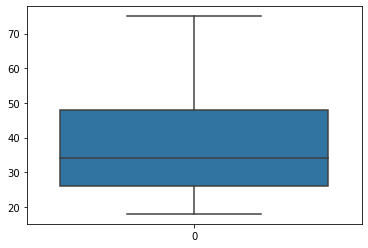

In [42]:
sns.boxplot(data=df['age'], width=0.8)

**Выбросов нет**

# Cоздать/ удалить переменные

In [43]:
import datetime as dt

In [44]:
df['date_start'] = pd.to_datetime(df['date_start']).dt.date

In [45]:
df['date_end'] = pd.to_datetime(df['date_end']).dt.date

In [46]:
df['delta'] = (df['date_end'] - df['date_start']).dt.days

In [47]:
df['dow_start'] = df['date_start'].apply(lambda x: x.isoweekday()) 

In [48]:
df['day_start'] = df['date_start'].apply(lambda x: x.day) 

In [50]:
df['month_start'] = df['date_start'].apply(lambda x: x.month) 

In [51]:
df['year_start'] = df['date_start'].apply(lambda x: x.year) 

In [52]:
df['dow_end'] = df['date_end'].apply(lambda x: x.isoweekday()) 

In [53]:
df['day_end'] = df['date_end'].apply(lambda x: x.day) 

In [54]:
df['month_end'] = df['date_end'].apply(lambda x: x.month) 

In [55]:
df['year_end'] = df['date_end'].apply(lambda x: x.year) 

In [56]:
df = df.drop(['date_start'], axis=1)

In [57]:
df = df.drop(['date_end'], axis=1)

In [58]:
df = df.drop(['id'], axis=1)

In [59]:
df.head()

,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus,delta,dow_start,day_start,month_start,year_start,dow_end,day_end,month_end,year_end
0,Мужской,44,0,Собственное,Гражданский брак/женат/замужем,0,Официальное,Новосибирская область,0,1,Нет,9,4,3,1,2013,6,12,1,2013
1,Мужской,21,0,Живут с родителями,Холост,0,Официальное,Кемеровская область юг,1,0,Нет,14,4,3,1,2013,4,17,1,2013
2,Мужской,25,0,Собственное,Холост,1,Официальное,Кемеровская область север,1,0,Нет,14,4,3,1,2013,4,17,1,2013
3,Женский,47,0,Собственное,Гражданский брак/женат/замужем,1,Официальное,Кемеровская область север,0,0,Нет,14,4,3,1,2013,4,17,1,2013
4,Мужской,22,0,Арендуемое,Гражданский брак/женат/замужем,0,Официальное,Кемеровская область север,1,1,Нет,14,4,3,1,2013,4,17,1,2013


# Закодировать категориальные переменные

In [60]:
df = pd.get_dummies(df
               ,columns = ['gender']
               ,prefix = 'gender'
               )

In [61]:
df = pd.get_dummies(df
               ,columns = ['housing']
               ,prefix = 'housing'
               )

In [62]:
df = pd.get_dummies(df
               ,columns = ['region']
               ,prefix = 'region'
               )

In [63]:
df = pd.get_dummies(df
               ,columns = ['marstatus']
               ,prefix = 'marstatus'
               )

In [64]:
df = pd.get_dummies(df
               ,columns = ['jobtype']
               ,prefix = 'jobtype'
               )

## Разбить выборку на обучающую и тестовую

In [65]:
from sklearn.model_selection import train_test_split

y = df.delinq60plus
X = df.drop(['delinq60plus'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7, 
                                                    random_state=42, 
                                                    stratify=y)

In [72]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

train_X_scaled = scaler.fit_transform(X_train)
test_X_scaled = scaler.fit_transform(X_test)

In [105]:
train_X_scaled. shape

(24262, 33)

In [106]:
test_X_scaled.shape

(10398, 33)

## Построить модель и оценить ее качество

In [73]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score (X_test, y_test)

0.7557222542796692

In [74]:
y_pred = rfc.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.8429129036284418

In [75]:
import matplotlib.pyplot as plt

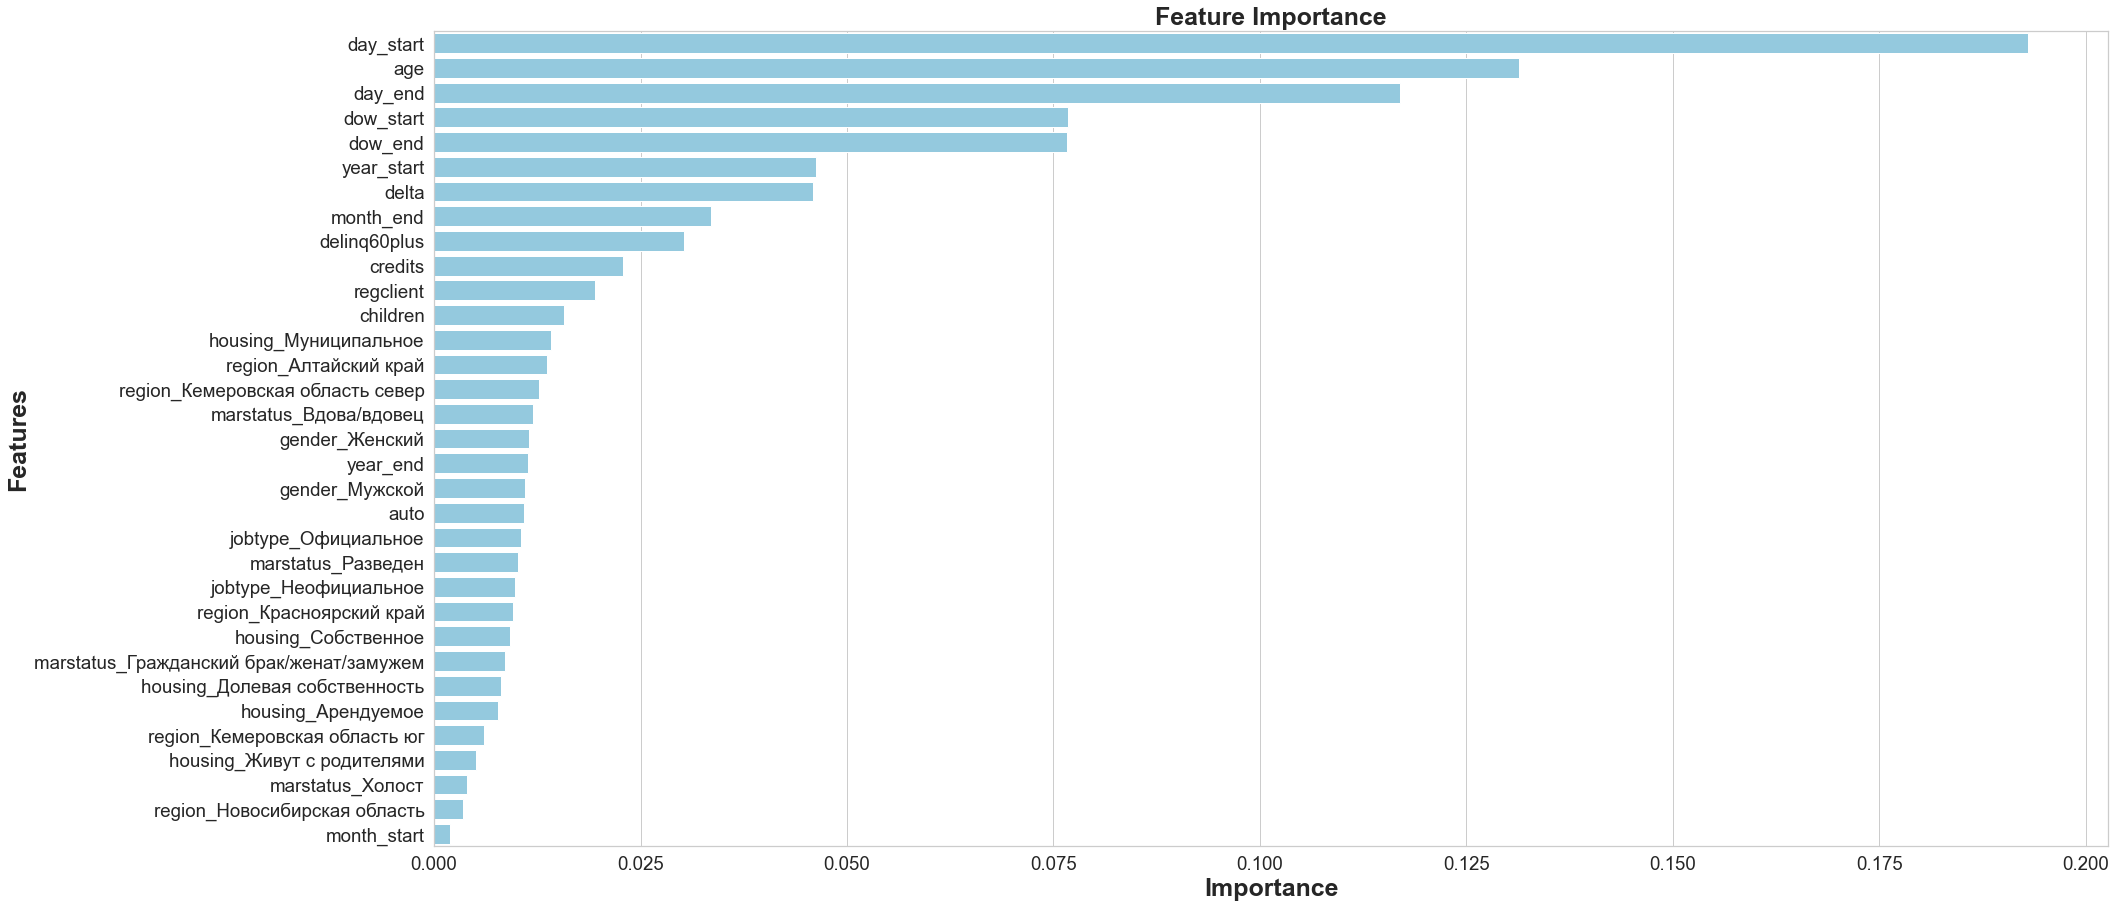

None

,Features,Importance
0,day_start,0.193045
1,age,0.131403
2,day_end,0.116972
3,dow_start,0.076723
4,dow_end,0.076640
5,year_start,0.046194
6,delta,0.045831
7,month_end,0.033479
8,delinq60plus,0.030252
9,credits,0.022885


In [76]:
feats = {}
for feature, importance in zip(df.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

# Метод главных компонент

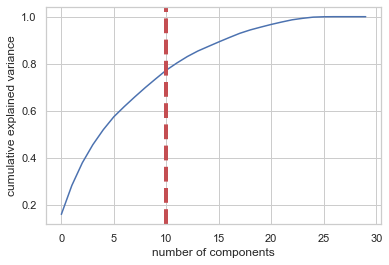

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.158016,0.158016
1,0.281124,0.123108
2,0.377757,0.096634
3,0.454698,0.076940
4,0.518816,0.064118
5,0.573665,0.054849
6,0.617331,0.043666
7,0.658507,0.041176
8,0.698183,0.039675
9,0.735727,0.037544


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
pca_test = PCA(n_components=30)
pca_test.fit(train_X_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [80]:
pca = PCA(n_components=10)
pca.fit(train_X_scaled)
X_train_scaled_pca = pca.transform(train_X_scaled)
X_test_scaled_pca = pca.transform(test_X_scaled)

In [84]:
pca_dims = []
columns = X_train.columns
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=columns, index=pca_dims)
pca_test_df.head(10).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9
age,0.071368,-0.082855,-0.082089,-0.057980,0.113987,0.040538,0.058939,0.083756,-0.081207,-0.025635
auto,-0.086943,0.046470,0.049872,-0.058311,0.020872,0.057110,0.067159,0.048960,-0.023877,0.005577
regclient,0.329346,-0.069756,0.146600,-0.138525,0.175865,0.083162,0.228298,-0.597589,0.472212,0.148836
credits,0.001618,-0.094568,0.050925,0.030483,-0.021464,0.969908,-0.108949,0.127282,-0.008711,0.061492
children,-0.159277,-0.277241,0.509434,0.046794,-0.087710,-0.078596,-0.099744,-0.074832,0.096141,0.045056
delta,-0.001285,-0.000996,-0.000369,0.004933,0.001223,-0.002163,-0.001607,0.004627,-0.001594,0.003623
dow_start,0.005956,0.006807,0.012183,-0.002394,0.015221,0.018090,0.005140,-0.369832,-0.536690,0.231357
day_start,0.010231,-0.007108,0.001278,-0.001699,0.010747,-0.003760,-0.024122,0.034397,0.094495,0.342682
month_start,0.056998,-0.037843,0.019239,-0.019394,0.030816,0.090984,0.344356,-0.154845,0.069319,-0.084151
year_start,0.002681,0.000295,0.001710,0.000172,0.001654,-0.001516,-0.011555,-0.002071,-0.003418,0.023845


# Обучение базовой RF-модели после применения к данным метода главных компонент 

In [85]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled_pca, y_train)
display(rfc.score(X_train_scaled_pca, y_train))

0.9999587832824994

# Оптимизация гиперпараметров. Раунд 1: RandomizedSearchCV

In [87]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_scaled_pca, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 600,
 'min_samples_split': 23,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}

In [88]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,600,23,2,sqrt,15,False,0.731597,1
1,800,28,12,sqrt,14,True,0.731473,2
2,700,23,7,log2,15,False,0.731020,3
3,400,23,2,sqrt,14,False,0.730979,4
4,700,12,2,sqrt,13,False,0.730979,5
5,300,28,7,log2,13,True,0.730855,6
6,700,2,2,log2,11,True,0.730608,7
7,600,50,23,sqrt,14,False,0.729742,8
8,300,2,23,log2,14,False,0.729660,9
9,500,12,18,sqrt,13,False,0.728959,10


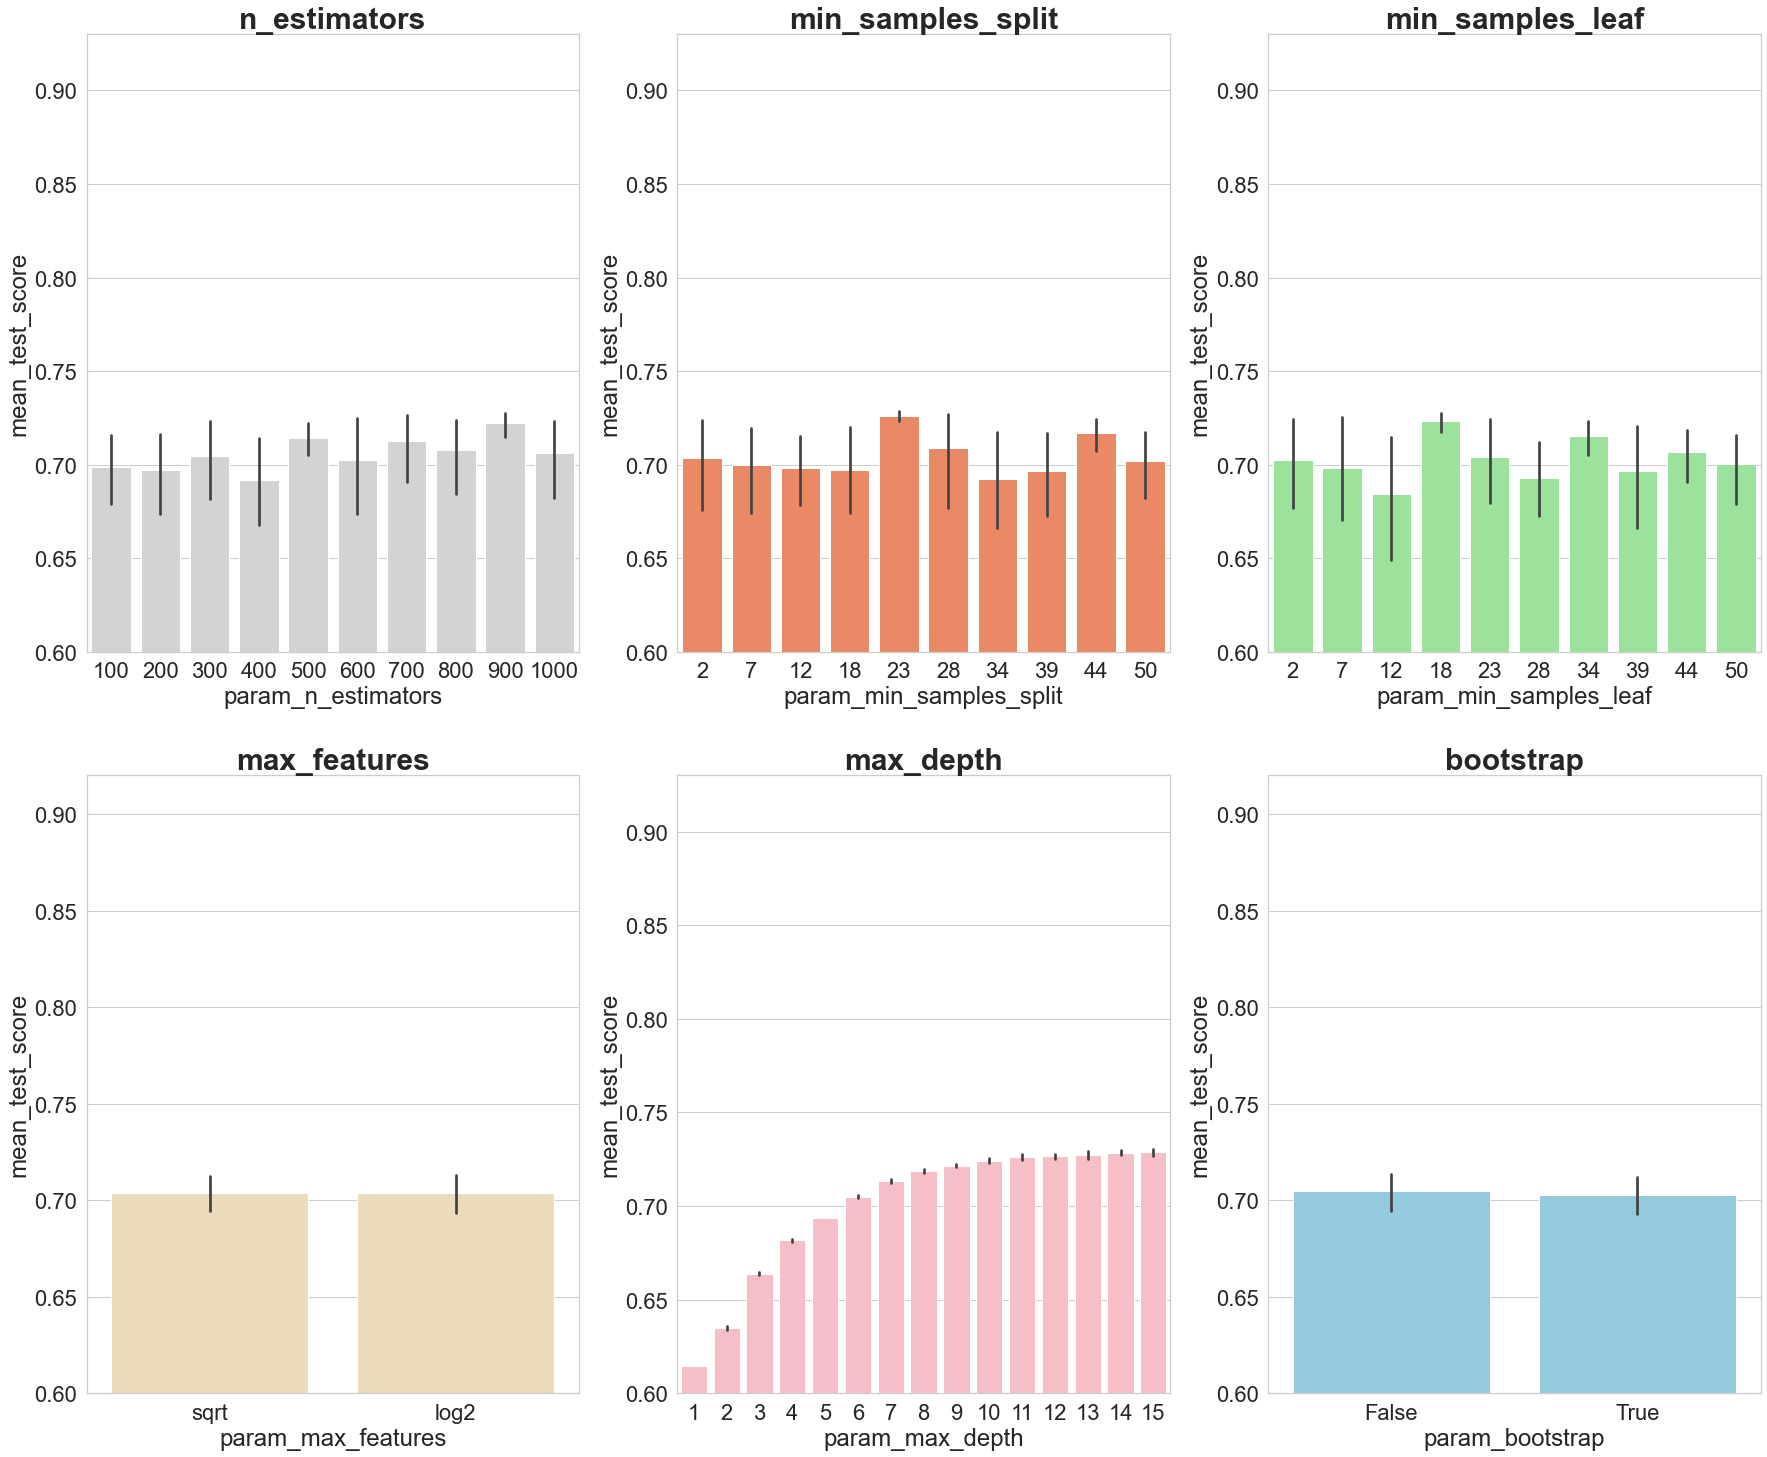

In [95]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.6,.93])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.6,.93])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.6,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.6,.92])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.6,.93])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.6,.92])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

# Оптимизация гиперпараметров. Раунд 2: GridSearchCV (окончательная подготовка параметров для модели)

In [97]:
from sklearn.model_selection import GridSearchCV
n_estimators = [500,700,900]
max_features = ['sqrt']
max_depth = [13,14,15]
min_samples_split = [2, 23, 28,44]
min_samples_leaf = [18,19,31,32,33,34]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_scaled_pca, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 18,
 'min_samples_split': 2,
 'n_estimators': 900}

# Оценка качества работы моделей на проверочных данных

In [114]:
y_pred = rfc.predict(test_X_scaled)
y_pred_pca = rfc.predict(X_test_scaled_pca)
y_pred_gs = gs.best_estimator_.predict(X_test_scaled_pca)

C:\Users\myshk\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\myshk\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: X has 10 features, but RandomForestClassifier is expecting 33 features as input.